In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
from scipy import stats
import math

from sklearn.neighbors import NearestNeighbors

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from modules.dp_func import *



In [3]:
# Set the mean and covariance matrix for each Gaussian distribution


mean1 = [0, 0, 0 , 0 , 0, 0, 0 , 0]
# covariance1 = np.ones((3,3))
covariance1 = np.identity(8)

mean2 = [2.56, 0, 0 , 0, 0, 0,0, 0 ]

# covariance2 = np.ones((3,3))
covariance2= np.identity(8)

#choose the number of samples per group. 
samples = 200

n0 = samples
n1 = samples

# p, q = .5, .5

\begin{align*}
p_k(x)  =\frac{k}{n} \frac{1}{ \frac{\pi^{p/2}}{\Gamma(p/2+1)}  \|x-x_k \|}.
\end{align*}

see here 
https://scikit-learn.org/stable/modules/neighbors.html#nei

In [4]:

def knn_density_calc(distances_matrix, k, p, n): # p is the dimension 
    vec = np.zeros(len(distances_matrix))
        
    gam_p = math.gamma( p /2 + 1)
    pi_power = (math.pi)**(p/ 2)
    vol_mult = pi_power / gam_p

    for i, dist_lst in enumerate(distances_matrix):
        dist = dist_lst[k-1]
        vol=  (dist**p) * vol_mult
        vec[i] =  k /  ( n * vol  )
    
    return vec
    

The cell below and the 2 below that work identically

In [5]:
# def kkn_density_bounds(density1, density2):
#     a = 50
#     gl_half = 1/a * np.log((1 + np.exp(-a)) / (np.exp(-a*1/2) + np.exp(-a*(1/2))))

#     # fx calculation
#     fx = 0.5 * (density1 + density2)  
#     px = density1 / (density1 + density2)

#     # integration
#     glx = 1/a * np.log((1 + np.exp(-a)) / (np.exp(-a*px) + np.exp(-a*(1-px)))) * fx 
    
#     gux = glx + (1 - 2 * gl_half) * 0.5 * np.sin(np.pi * px)* fx 
    
#     return np.sum(glx), np.sum(gux), px


In [6]:
def g_L(p, alpha):
    return 1/alpha * np.log(np.cosh(alpha/2) / np.cosh(alpha * (p - 1/2)))
#     return 1/alpha * np.log((1 + np.exp(-alpha)) / (np.exp(-alpha * p) + np.exp(-alpha * (1 - p))))


def g_C(p):
    return ( 1/2 * np.sin( np.pi * p ) )

def g_U(p, alpha,  g_L, g_C):
    return g_L(p, alpha) + (1 - 2 * g_L(0.5, alpha)) * g_C(p)

In [7]:

## This has to be my problem cell

def kkn_density_bounds(density1, density2):
    # fx calculation
    fx = 0.5 * (density1 + density2) 

    px = density1 / (density1 + density2)
    
    magic = 1/ sum(fx)  # in theory 1 = sum(fx) * dx  so magic = dx
#     print(magic)

#     magic = 1

    alpha = 50
    
    glx = np.sum( g_L(px, alpha)*fx * magic   )
    gux = np.sum( g_U(px, alpha, g_L, g_C) * fx * magic)
    
    return glx, gux, px

In [8]:

bounds_l = []
bounds_u = []

knn_l = []
knn_u = []

MC_num = 200

k = 20

for i in range(MC_num):
    # Generate random samples from the multivariate normal distributions
    data1 = np.random.multivariate_normal(mean1, covariance1, n0)
    data2 = np.random.multivariate_normal(mean2, covariance2, n1)

    X = np.concatenate([data1, data2])
    
    
    p = len(mean1) #dimension

    # Fit k-Nearest Neighbors model and get densitities for data set 1
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(data1)
    distances, indices = knn.kneighbors(X)

    density1 = knn_density_calc(distances, k, p, n0)
    
    # Fit k-Nearest Neighbors model and get densitities for data set 2
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(data2)
    distances, indices = knn.kneighbors(X)    
    
    density2 = knn_density_calc(distances, k, p, n1)
    
    u, l, px= kkn_density_bounds(density1, density2)
    
    knn_l.append(l)
    knn_u.append(u)
    
    
    lower, upper = get_bounds(data1, data2, n0, n1)

    bounds_l.append(lower)
    bounds_u.append(upper)
    

    


1.343362403442163e-05 3.104458732909319e-06 0.7689038546147627


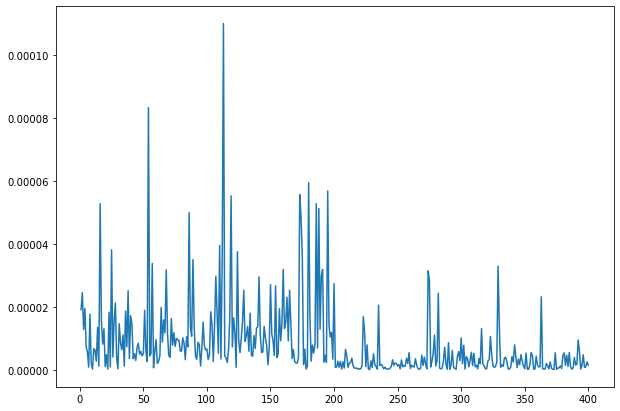

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

x_val = np.linspace(1, n0 +n1, n0+n1)
ax.plot(x_val,density1)

a = np.mean(density1[:n0])
b =  np.mean(density1[n0:])
print( a, b, (a - b)/a)

In [10]:
print(stats.describe(knn_l), "\n")

print(stats.describe(knn_u))

DescribeResult(nobs=200, minmax=(0.10491462870307879, 0.2324052835235591), mean=0.16155065310085803, variance=0.0005114063309184194, skewness=0.34972831885559863, kurtosis=0.1579559489762845) 

DescribeResult(nobs=200, minmax=(0.10102384425049912, 0.22429462504925143), mean=0.15569595867828376, variance=0.00047817837743982197, skewness=0.35332017323911374, kurtosis=0.163754372149453)


In [11]:
print(stats.describe(bounds_l))
print(stats.describe(bounds_u))

DescribeResult(nobs=200, minmax=(0.056998871333266254, 0.14118249763981688), mean=0.09758113607239295, variance=0.00024151553287847676, skewness=0.19004353030753665, kurtosis=-0.2380101918935318)
DescribeResult(nobs=200, minmax=(0.10749999999999998, 0.2425), mean=0.1756375, variance=0.0006216078831658292, skewness=0.09003495851740115, kurtosis=-0.26634174628571916)


In [12]:
dx = 0.001
x = np.arange(-5, 10 + dx, dx)

f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
f1 = np.exp(-0.5 * (x - 2.56)**2) / np.sqrt(2 * np.pi)

fmin = np.minimum(f0, f1)

BER = 0.5 * np.sum(fmin * dx)

print("BER 2d:", BER)

BER 2d: 0.10027258671145799


In [13]:
# BER_lst = np.ones(MC_num) * BER


# mse_l = ((BER_lst - bounds_l)**2).mean(axis=0)

# mse_u =  ((BER_lst - bounds_u)**2).mean(axis=0)

# print(mse_l, mse_u)

In [14]:
sum(px)

198.66774419036184

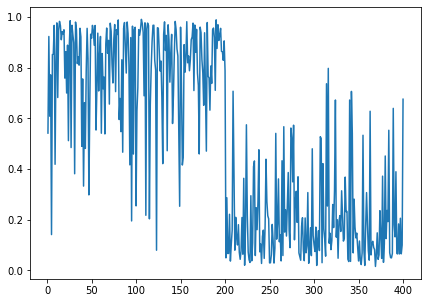

In [15]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

x_val = np.linspace(1, n0 +n1,n0+n1)
ax.plot(x_val, px)

plt.show()